In [1]:
%pylab inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
set_printoptions(linewidth=300, threshold=200000, suppress=True, precision = 8)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#figsize(16,9)
def rf1h(dx, N, p):
    e, No = p
    dN = e * No * (N > 0)
    return -dN * dx

def rf1r(dx, N, p):
    e = p[0]
    dN = - e * N
    return dN * dx


def rf2h(dx, N, p):
    a, Ht, No = p
    dN = (a * No) / (1 + a * Ht * No) * (N > 0)
    #print (p, dN, -dN * dx, dx)
    return -dN * dx

def rf2r(dx, N, p):
    a, Ht, No = p
    dN = (a * N) / (1 + a * Ht * N)
    return -dN * dx


def rf3h(dx, N, p):
    a, Ht, No = p
    N2 = No ** 2
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    return -dN * dx

def rf3r(dx, N, p):
    a, Ht, No = p
    N2 = N ** 2
    dN = (a * N2) / (1 + a * Ht * N2)
    return -dN * dx

def rfgh(dx, N, p):
    a, Ht, k, No = p
    N2 = No ** k
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    return -dN * dx

def rfgr(dx, N, p):
    a, Ht, k, No = p
    N2 = N ** k
    dN = (a * N2) / (1 + a * Ht * N2)
    return -dN * dx


def rfl(dx, sv, p):
    """
    Functional response with learning
    la = learning in a
    lH = learning in handling time
    Mnt = minimum handling time
    ha = host depletion
    No = N initial
    sv = state variables
    """
    N, a, Ht = sv
    la, lH, Mnt, hd, No = p[:5]
    #print(la, lH, N, a, Ht)
    if hd: N2 = N
    else:  N2 = No
    
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    da = la * (1 - a) * dN
    dH = lH * (Ht - Mnt) * dN
    return array([-dN, da, -dH]) * dx


def rk4(f, h, y, p):
    dx = h
    k1 = f(dx, y, p)
    k2 = f(dx, y + k1 / 2, p)
    k3 = f(dx, y + k2 / 2, p)
    k4 = f(dx, y + k3, p)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def plot_funcion(f, p, nombre = '', grafica = "integral", sv = 1, tmax = 1, ax = False):
    import crf_dinamica as rf
    if len(p) == 7:
        fraccion = 1024
    else:
        fraccion = 128
    y = zeros((tmax * fraccion + 1, sv))
    x = linspace(0, tmax, tmax * fraccion + 1)
    
    y[0] = p[-sv:]
    if len(p) == 7:
        y = rf.rfl(array(p, dtype = float64), tmax)
    else:
        for i in range(1, y.shape[0]):
            y[i] = rk4(f, x[1] - x[0], y[i-1], p)
        y[:,0] = y[0,0] - y[:,0]
    if grafica == "integral":
        ax.plot(x, y[:,0], label = nombre)
    elif grafica == "derivada":
        ax.plot(x[1:], (y[1:,0] - y[:-1,0]), label = nombre)
    return x, y

def plot_rfn(f, p, nombre = '', grafica = "integral", sv = 1, tmax = 1, Nmax = 100, ax = False):
    
    x = linspace(0.5, Nmax, Nmax * 2)
    y = zeros_like(x)
    for i in range(x.shape[0]):
        p[-sv] = x[i]
        xx, N = plot_funcion(f, p, grafica = '', sv = sv, tmax = tmax, ax = ax)
        y[i] = N[-1, 0]
    if grafica == "integral":
        ax.plot(x, y, label = nombre)
    elif grafica == "derivada":
        ax.plot(x[:-1], 2 * (y[1:] - y[:-1]), label = nombre)
    elif grafica == "derivada2":
        dy = 2 * (y[1:] - y[:-1])
        d2 = dy[1:] - dy[:-1]
        #print(dy.max(), dy.min(), d2.max(), d2.min())
        ax.plot(x[1:-1], (dy[1:] - dy[:-1]), label = nombre)
    elif grafica == 'd20':
        dy =  y[1:] -  y[:-1]
        d2 = dy[1:] - dy[:-1]
        d2s = array(where(sign(d2[1:]) != sign(d2[:-1]))) * (x[1] - x[0])
        if d2s.size == 0:
            d2s = array([Nmax + 1])
        #print(" %3d %3d %3d %8.4f %8.4f %8.4f"%(len(y), len(dy), len(d2), d2s.min(), d2.max(), d2.min()), end = ' ')
        #sys.stdout.flush()
        return d2s.min(), d2.max(), d2.min()
    return x,y

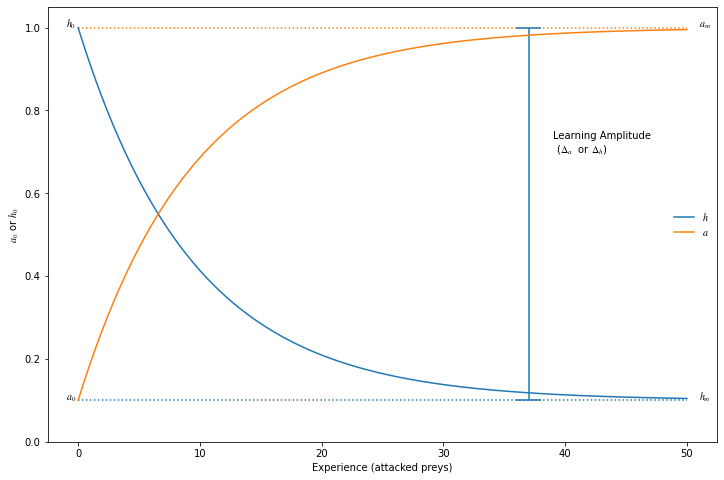

In [3]:
figsize(12,8)

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
x = linspace(0,50,401)
plot(x, 0.1 + 0.9 *(0.9**(x)), "C0", label = "$h$")
plot(x, 0.1 + 0.9 *(1-0.9**(x)), "C1", label = "$a$")
text(-1, 0.1,"$a_0$")
text(-1, 1.0,"$h_0$")
text(51,0.1,"$h_m$")
text(51,1.0,"$a_m$")
hlines(0.1, 0, 50, 'C0', linestyles = "dotted")
hlines(1.0, 0, 50, 'C1', linestyles = "dotted")
hlines(0.1, 36, 38)
hlines(1.0, 36, 38)
vlines(37, 0.1, 1.0)
text(39, 0.7, "Learning Amplitude\n ($\Delta_a$  or $\Delta_h$)")
ylim(0,1.05)
ylabel("$a_0$ or $h_0$")
xlabel("Experience (attacked preys)")
legend(frameon = False, loc = 5)
show()